AR non-anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates a 9 panel plot with the following variables in the columns
1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (ivt) 
3. (precip)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days

In [6]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

def mjo_index(ref, start_date, end_date):
    '''create a pandas df of the Madden Julian Oscillation index 
    on daily, monthly, or seasonal timescale 
    with yes MJO phase as positive, no MJO phase as negative
    '''
    fname_daily = path_to_data + 'teleconnection_indices/mjo.events.ouu.1979.2019.txt'
    df = pd.read_csv(fname_daily, delim_whitespace=True, engine='python')
    df['date'] = pd.date_range('1979-01-01 9:00:00', '2019-12-31 9:00:00', freq='1D')
    df = df.set_index('date')
    
    if ref == 'daily':
        # (yes MJO) positive = 1, (no MJO) negative = -1
        df['COND'] = 0
        idx = (df['PHA']>0) & (df['AMPLITUDE']>1)
        df.loc[idx, 'COND'] = 1
        df.loc[df['PHA']==0, 'COND'] = -1

    elif ref == 'monthly':
        print('No monthly capabilities yet')
        
    elif ref == 'seasonal':
        print('No seasonal capabilities yet')
    
    # trim to start_date, end_date
    idx = (df.index >= start_date) & (df.index <= end_date + " 23:59:59")
    df = df.loc[idx]
        
    return df

### Climate Indices

In [7]:
start_date = '1979-12-01'
end_date = '2019-05-31'
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
tele

,AO,PDO,ENSO,SH,MJO
date,,,,,
1979-12-01 09:00:00,1,0,0,0,1
1979-12-02 09:00:00,1,0,0,0,1
1979-12-03 09:00:00,1,0,0,0,1
1979-12-04 09:00:00,1,0,0,0,1
1979-12-05 09:00:00,1,0,0,0,1
...,...,...,...,...,...
2019-05-27 09:00:00,0,0,1,1,1
2019-05-28 09:00:00,-1,0,1,1,1
2019-05-29 09:00:00,-1,0,1,1,1


In [8]:
df_index = select_months(tele, 12, 5)
df = ar_daily_df(ssn, nk)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


### ERA5 renalysis

In [9]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []
# # Select lat/lon grid
# lonmin = plot_dicts[1]['bnds'][0]
# lonmax = plot_dicts[1]['bnds'][1]
# latmin = plot_dicts[1]['bnds'][2]
# latmax = plot_dicts[1]['bnds'][3]

# Select lat/lon grid
lonmin = 20.
lonmax = 110
latmin = 10
latmax = 50

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))


In [10]:
uvec = f[1]['p71.162'].values
vvec = f[1]['p72.162'].values
ivt = np.sqrt(uvec**2 + vvec**2)

var_dict = {'H': (['time', 'lat', 'lon'], (f[0]['z'].values/(9.80665))), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values),
            'ivt': (['time', 'lat', 'lon'], ivt)}


ds1 = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds1
print('ds size in GB {:0.2f}\n'.format(ds1.nbytes / 1e9))

ds_lst = [ds1, ds2]

ds size in GB 5.27



### Combine with data

In [11]:
df = new_df
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    ds_lst[i] = ds

In [12]:
ds_lst[0]

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 181, time: 7290)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 12.0 11.5 11.0 10.5 10.0
  * lon      (lon) float32 20.0 20.5 21.0 21.5 22.0 ... 108.5 109.0 109.5 110.0
    AR_CAT   (time) int64 3 3 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    AO       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... -1 -1 0 0 0 0 0 -1 -1 -1 0
    PDO      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    ENSO     (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    SH       (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    H        (time, lat, lon) float32 10274.625 10270.929 ... 10995.336 10994.81
    U        (time, lat, lon) float32 33.950375 34.228924 ... -13.427866
    V        (time, lat, lon) float32 -9.823039 -9.924035 ... -3.5885582
    ivte     (time, lat, lon) float32 313.29895 318.18585 ... -227.57889
    ivtn     (time, lat, lon) float32 -141.96028 -153.8484 ... 4.8195877
    ivt      (time, lat, lon) float32 343.9607 353.4283 ... 227.60307 227.62991

### Compute AR Composites

### Figures

### Common Plot Properties

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


### Composite Plots

-73.509766 26.029297
-84.65918 18.083008
-37.166016 24.5625
-82.12598 20.517578
-92.59961 54.075195
-44.972656 33.26758
-93.95996 37.020508
-91.81738 2.241211
-67.416016 42.648438
-75.112305 26.83496
-0.9863281 71.08789
-55.804688 44.841797


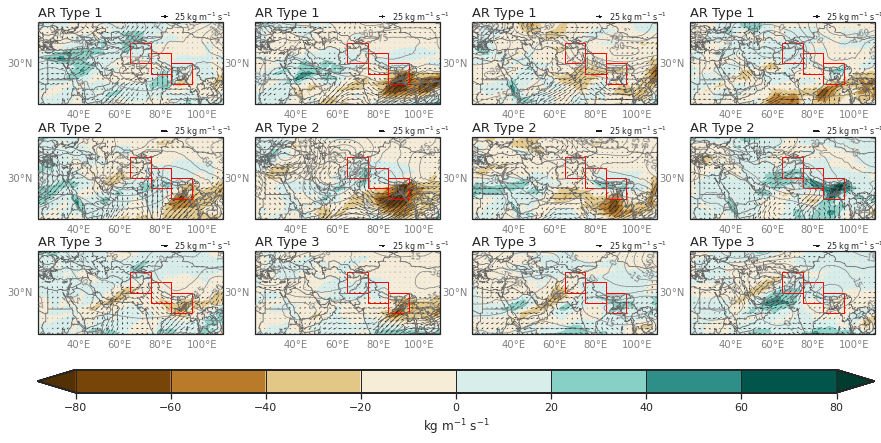

In [21]:
filepath = fig_path + 'composite_diff_clim_indices.png'
nrows = nk
ncols = 4
artype_lst = [1, 2, 3]*4
tele_lst = ['ENSO']*3 + ['AO']*3 + ['SH']*3 + ['MJO']*3

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='7%',label_mode='',
                direction='column')
for k, (ax, tele, ar_type) in enumerate(zip(axgr, tele_lst, artype_lst)):
    ds = ds_lst[0]
    idx = (ds[tele] == 1) & (ds['AR_CAT'] == ar_type)
    data1 = ds.sel(time=idx).mean('time')
    idx = (ds[tele] == 0) & (ds['AR_CAT'] == ar_type)
    data2 = ds.sel(time=idx).mean('time')

    data = data1-data2
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

    # Contour Filled

    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
#         ivt = np.sqrt(uvec**2 + vvec**2)
    ivt = data.ivt.values
#         ivt_sm = gaussian_filter(ivt, sigma=1.5)
    cflevs = np.arange(-80, 100, 20)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap='BrBG', alpha=0.9, extend='both') 

    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})

    # Contour Lines
    # 250-hPa Heights
    hgts = data.H.values #convert to decimeters
    print(hgts.min(), hgts.max())
    clevs = np.arange(-105, 75, 15)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 

#     # Contour Lines
#     # Precip
#     ds = ds_lst[1]
#     idx = (ds[tele] == 1) & (ds['AR_CAT'] == ar_type)
#     data1 = ds.sel(time=idx).mean('time')
#     idx = (ds[tele] == 0) & (ds['AR_CAT'] == ar_type)
#     data2 = ds.sel(time=idx).mean('time')
#     data = data1-data2
#     # lat/lon arrays
#     lats = data.lat.values
#     lons = data.lon.values
#     prec = data.prec.values
#     prec_sm = gaussian_filter(prec, sigma=2.0)
#     clevs = np.arange(-10, 15, 5)
#     cs = ax.contour(lons, lats, prec_sm, transform=datacrs,
#                     levels=clevs, colors='k', linewidths=1.5)


    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)

# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('kg m$^{-1}$ s$^{-1}$')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [35]:
era_ar_comp = []
for i, ds in enumerate(ds_lst):
    
    # composite ENSO = 1, AR = 3
    idx = (ds['ENSO'] == 1) & (ds['AR_CAT'] == 3)
    tmp1 = ds.sel(time=idx).mean('time')
    # composite ENSO = -1, AR = 3
    idx = (ds['ENSO'] == -1) & (ds['AR_CAT'] == 3)
    tmp2 = ds.sel(time=idx).mean('time')
    # composite difference
    tmp = tmp1 - tmp2
    era_ar_comp.append(tmp)
    
    # composite AO = 1, AR = 3
    idx = (ds['AO'] == 1) & (ds['AR_CAT'] == 3)
    tmp1 = ds.sel(time=idx).mean('time')
    # composite AO = -1, AR = 3
    idx = (ds['AO'] == -1) & (ds['AR_CAT'] == 3)
    tmp2 = ds.sel(time=idx).mean('time')
    # composite difference
    tmp = tmp1 - tmp2
    era_ar_comp.append(tmp)
    
    # composite SH = 1, AR = 3
    idx = (ds['SH'] == 1) & (ds['AR_CAT'] == 3)
    tmp1 = ds.sel(time=idx).mean('time')
    # composite SH = -1, AR = 3
    idx = (ds['SH'] == -1) & (ds['AR_CAT'] == 3)
    tmp2 = ds.sel(time=idx).mean('time')
    # composite difference
    tmp = tmp1 - tmp2
    era_ar_comp.append(tmp)
    
    # composite MJO = 0, AR = 1
    idx = (ds['MJO'] == 0) & (ds['AR_CAT'] == 1)
    tmp1 = ds.sel(time=idx).mean('time')
    # composite MJO = 1, AR = 1
    idx = (ds['MJO'] == 1) & (ds['AR_CAT'] == 1)
    tmp2 = ds.sel(time=idx).mean('time')
    # composite difference
    tmp = tmp1 - tmp2
    era_ar_comp.append(tmp)

-9.366787393626414 12.117848631582762
-8.249537312955619 4.665088807472269
-6.548278775660932 5.988234106232138
-12.299745385652276 10.278508221939445


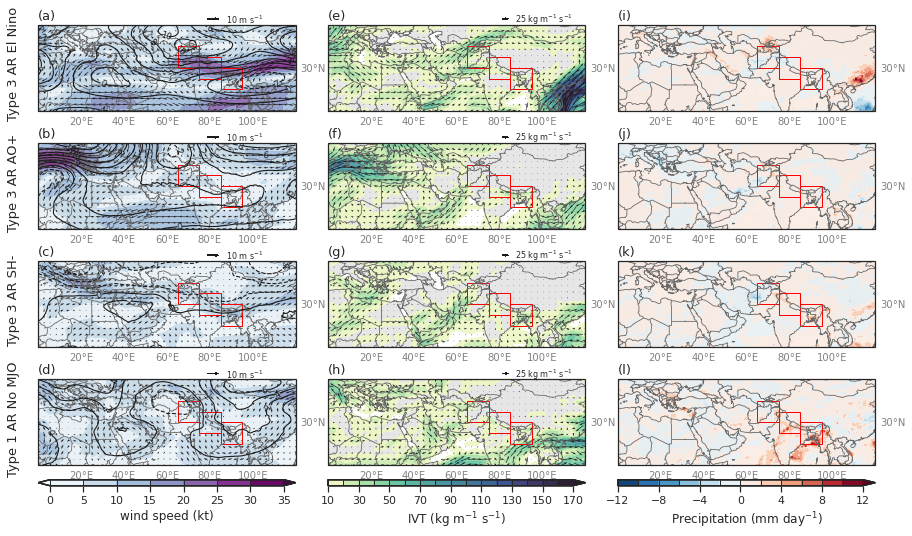

In [39]:
filepath = fig_path + 'composite_climate_indices'  + '.png'
nrows = 4
ncols = fig_dict['ncols']

row_lbl = ['Type 3 AR El Nino', 'Type 3 AR AO+', 'Type 3 AR SH-', 'Type 1 AR No MJO']
col_lbl1 = ['(a)', '(b)', '(c)', '(d)']
col_lbl2 = ['(e)', '(f)', '(g)', '(h)']
col_lbl3 = ['(i)', '(j)', '(k)', '(l)']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

artype_lst = [0, 1, 2, 3]
#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):
    data = era_ar_comp[ar_type]
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values/10. #convert to dekameters
    clevs = np.arange(-20, 20, 2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
#     plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(col_lbl1[k], loc='left',fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    
# Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
    data = era_ar_comp[ar_type]
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
    ax.set_title(col_lbl2[k], loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################
artype_lst = [4, 5, 6, 7]
for k, (ax, ar_type) in enumerate(zip(axgr[nrows+nrows:], artype_lst)):
    data = era_ar_comp[ar_type]
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cflevs = np.arange(-12, 14, 2)
#     cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cmap = 'RdBu_r'
    prec = data.prec.values
    print(prec.min(), prec.max())
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
    ax.set_title(col_lbl3[k], loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [14]:
clevs = np.arange(100, 275, 50)
clevs

cmap_data = [
             (0, 160, 255), # light blue 200-300
             (230, 220, 50), # yellow 800-900
             (250, 60, 60), # light red 2000-2100
            ]

my_cmap = make_cmap(cmap_data, bit=True)